In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving deu.txt to deu.txt


In [0]:
file_name = "deu.txt"
uploaded[file_name].decode("utf-8")

In [0]:
data = uploaded[file_name].decode("utf-8")

In [0]:
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t')[0:-1] for i in sents]
      return sents

In [0]:
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [0]:
deu_eng = deu_eng[:50000,:]

In [8]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.'],
       ['You need to apologize.', 'Du musst dich entschuldigen.']],
      dtype='<U537')

**Text Pre-Processing**

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen'],
       ['You need to apologize', 'Du musst dich entschuldigen']],
      dtype='<U537')

In [10]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['you need not go there', 'du musst nicht dorthin gehen'],
       ['you need not go there', 'du brauchst nicht dorthin zu gehen'],
       ['you need to apologize', 'du musst dich entschuldigen']],
      dtype='<U537')

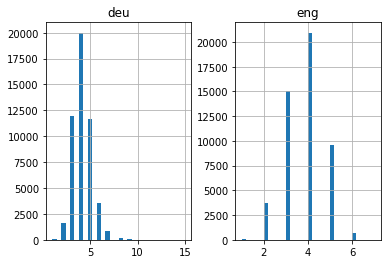

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

**Now we will prepare tokenizers for both the German and English sentences:**

In [0]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [13]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
eng_vocab_size

6331

In [15]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
deu_vocab_size

10455

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [19]:
train

array([['tom often does that', 'tom macht das oft'],
       ['did tom eat anything', 'hat tom irgendetwas gegessen'],
       ['its already too late', 'es ist schon zu spät'],
       ...,
       ['he lay on the bed', 'er lag auf dem bett'],
       ['i know who likes tom', 'ich weiß wer tom mag'],
       ['attention please', 'bitte aufpassen']], dtype='<U537')

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [21]:
trainX

array([[   1,  109,    5, ...,    0,    0,    0],
       [   9,    1, 1705, ...,    0,    0,    0],
       [   7,    3,   93, ...,    0,    0,    0],
       ...,
       [  11,  929,   23, ...,    0,    0,    0],
       [   2,   68,   53, ...,    0,    0,    0],
       [  56, 4878,    0, ...,    0,    0,    0]], dtype=int32)


We’ll start off by defining our Seq2Seq model architecture:

*   For the encoder, we will use an embedding layer and an LSTM layer
*   For the decoder, we will use another LSTM layer followed by a dense layer



In [0]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [0]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [26]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=30, batch_size=512, validation_split = 0.2,verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 7s 229us/step - loss: 3.4608 - val_loss: 2.9159
Epoch 2/30
32000/32000 [==============================] - 5s 158us/step - loss: 2.8106 - val_loss: 2.7864
Epoch 3/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.6308 - val_loss: 2.5798
Epoch 4/30
32000/32000 [==============================] - 5s 157us/step - loss: 2.4517 - val_loss: 2.4572
Epoch 5/30
32000/32000 [==============================] - 5s 158us/step - loss: 2.3008 - val_loss: 2.3533
Epoch 6/30
32000/32000 [==============================] - 5s 155us/step - loss: 2.1606 - val_loss: 2.2454
Epoch 7/30
32000/32000 [==============================] - 5s 156us/step - loss: 2.0393 - val_loss: 2.1668
Epoch 8/30
32000/32000 [==============================] - 5s 155us/step - loss: 1.9310 - val_loss: 2.0951
Epoch 9/30
32000/32000 [==============================] - 5s 156us/step - loss: 1.8270 - val_loss: 2.00

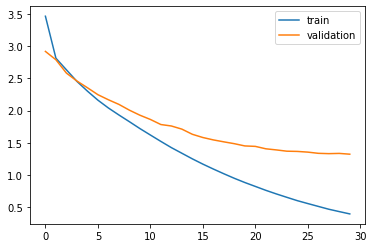

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [0]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [33]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
7774,i agreed with her,i used for with you
3692,i can wait no longer,i cant wait
3216,i didnt believe them,i didnt believe you
2021,its very hot today,its is hot today
836,tom arrived too early,tom arrived too late
9485,i considered tom,i felt tom with tom
6014,she spoke rapidly,she spoke too fast
1905,can you stop it,can you be it
7732,its comfortable,its secret
5112,tom has asthma,tom has immunity
